Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1109/1109 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 2.4547e-04 - val_loss: 6.3358e-05
Epoch 2/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 1.6336e-04 - val_loss: 6.1708e-05
Epoch 3/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 1.2079e-04 - val_loss: 5.4222e-05
Epoch 4/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1.5022e-04 - val_loss: 4.5074e-05
Epoch 5/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.0562e-04 - val_loss: 4.4282e-05
Epoch 6/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 8.2421e-05 - val_loss: 4.8814e-05
Epoch 7/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 9.9525e-05 - val_loss: 4.2783e-05
Epoch 8/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 8.3635e-05 - val_loss: 4.3981e-05
Epoch 9/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 9.1672e-05 - val_loss: 4.2780e-05
Epoch 10/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 8.3468e-05 - val_loss: 4.4137e-05
Epoch 11/25
1109/1109 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1109/1109 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 3.8370e-04 - val_loss: 5.8574e-05
Epoch 2/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.1393e-04 - val_loss: 5.2608e-05
Epoch 3/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 8.8256e-05 - val_loss: 5.0430e-05
Epoch 4/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1.4095e-04 - val_loss: 4.9333e-05
Epoch 5/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 9.8909e-05 - val_loss: 4.8206e-05
Epoch 6/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 8.6002e-05 - val_loss: 4.7927e-05
Epoch 7/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 8.9442e-05 - val_loss: 4.7299e-05
Epoch 8/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 7.9543e-05 - val_loss: 4.3352e-05
Epoch 9/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.2384e-04 - val_loss: 4.6860e-05
Epoch 10/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 1.3654e-04 - val_loss: 4.5712e-05
Epoch 11/25
1109/1109 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1109/1109 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 3.2901e-04 - val_loss: 1.5956e-04
Epoch 2/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 1.2315e-04 - val_loss: 5.5168e-05
Epoch 3/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 9.8016e-05 - val_loss: 5.4430e-05
Epoch 4/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 9.2064e-05 - val_loss: 5.4881e-05
Epoch 5/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.3959e-04 - val_loss: 5.0270e-05
Epoch 6/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 8.7560e-05 - val_loss: 5.3866e-05
Epoch 7/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 9.0265e-05 - val_loss: 4.7371e-05
Epoch 8/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 1.0615e-04 - val_loss: 4.5981e-05
Epoch 9/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 9.2082e-05 - val_loss: 5.1112e-05
Epoch 10/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1.3880e-04 - val_loss: 4.7651e-05
Epoch 11/25
1109/1109 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1109/1109 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 7.4856e-04 - val_loss: 7.1517e-05
Epoch 2/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.3007e-04 - val_loss: 6.7982e-05
Epoch 3/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 8.9442e-05 - val_loss: 6.1150e-05
Epoch 4/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1.2404e-04 - val_loss: 8.0712e-05
Epoch 5/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 8.3765e-05 - val_loss: 8.1208e-05
Epoch 6/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1.1669e-04 - val_loss: 5.4952e-05
Epoch 7/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 1.0868e-04 - val_loss: 4.8443e-05
Epoch 8/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 7.3910e-05 - val_loss: 5.4674e-05
Epoch 9/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 9.0338e-05 - val_loss: 4.6112e-05
Epoch 10/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 9.5644e-05 - val_loss: 4.7178e-05
Epoch 11/25
1109/1109 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1109/1109 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 3.5433e-04 - val_loss: 5.4412e-05
Epoch 2/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 9.0182e-05 - val_loss: 5.7267e-05
Epoch 3/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 8.4497e-05 - val_loss: 5.3247e-05
Epoch 4/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 7.6902e-05 - val_loss: 5.3421e-05
Epoch 5/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 7.3626e-05 - val_loss: 5.0066e-05
Epoch 6/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 6.9668e-05 - val_loss: 5.7695e-05
Epoch 7/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 6.5834e-05 - val_loss: 5.1804e-05
Epoch 8/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 6.6209e-05 - val_loss: 4.6222e-05
Epoch 9/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 6.2233e-05 - val_loss: 4.8384e-05
Epoch 10/25
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 6.5222e-05 - val_loss: 4.4344e-05
Epoch 11/25
1109/1109 ━━━━━━━━

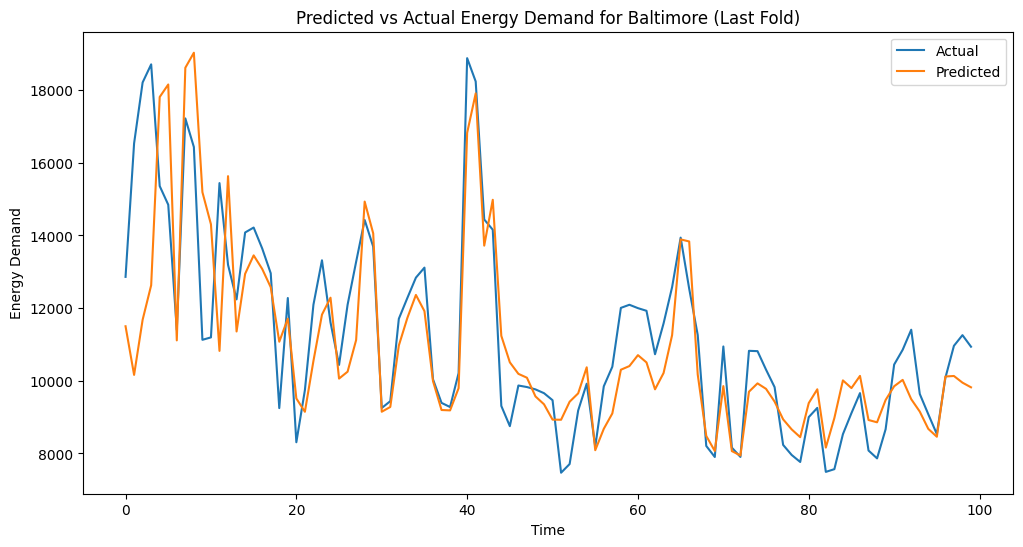

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_excel('Chicago.xlsx')
df = df.dropna()

features = df[['Temperature', 'DewPoint', 'RelativeHumidity', 'Precipitation', 'WindSpeed', 'Pressure']].values
energy_demand = df['EnergyDemand'].values.reshape(-1, 1)
dates = df['l'].values

scaler_features = MinMaxScaler()
scaler_energy = MinMaxScaler()
features_normalized = scaler_features.fit_transform(features)
energy_demand_normalized = scaler_energy.fit_transform(energy_demand)

def create_sequences(data, target, dates, seq_length):
    sequences = []
    targets = []
    sequence_dates = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target_seq = target[i+seq_length]
        date_seq = dates[i+seq_length]
        sequences.append(seq)
        targets.append(target_seq)
        sequence_dates.append(date_seq)
    return np.array(sequences), np.array(targets), np.array(sequence_dates)

seq_length = 24
X, y, dates_seq = create_sequences(features_normalized, energy_demand_normalized, dates, seq_length)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
mae_scores = []
mape_scores = []

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

result_df = pd.DataFrame()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dates_test = dates_seq[test_index]

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2])),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

    predictions_normalized = model.predict(X_test)

    predictions = scaler_energy.inverse_transform(predictions_normalized)
    y_test_original = scaler_energy.inverse_transform(y_test)

    mse = mean_squared_error(y_test_original, predictions)
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)
    mse_scores.append(mse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    fold_results = pd.DataFrame({
        'Date': dates_test,
        'Actual': y_test_original.flatten(),
        'Predicted': predictions.flatten()
    })
    result_df = pd.concat([result_df, fold_results], ignore_index=True)

result_df.to_csv('chicago_predictions.csv', index=False)

average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
average_mape = np.mean(mape_scores)
print(f"Average Mean Squared Error: {average_mse}")
print(f"Average Mean Absolute Error: {average_mae}")
print(f"Average Mean Absolute Percentage Error: {average_mape}")

plt.figure(figsize=(12, 6))
plt.plot(result_df['Actual'][:100], label='Actual')
plt.plot(result_df['Predicted'][:100], label='Predicted')
plt.title('Predicted vs Actual Energy Demand for Baltimore (Last Fold)')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()